In [39]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

total_variation_weight = 5e-7
style_weight = 1e-5
content_weight = 2.5e-8

#
#total_variation_weight = 1e-8
#style_weight = 5e-5 #generated6
#content_weight = 1e-10

In [42]:
base_image_path = "/content/drive/MyDrive/ColabNotebooks/02_TestData/Content_.png"
style_reference_image_path = "/content/drive/MyDrive/ColabNotebooks/02_TestData/Style.jpg"
result_prefix = 'london_generated'

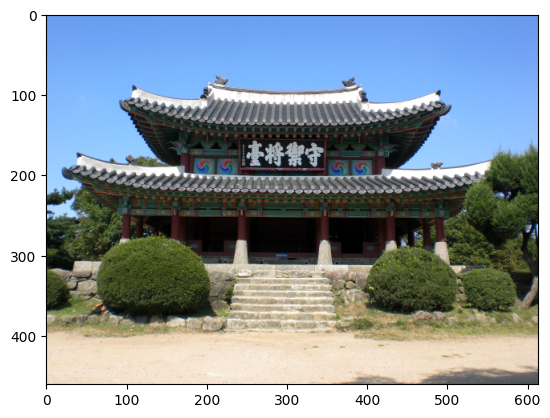

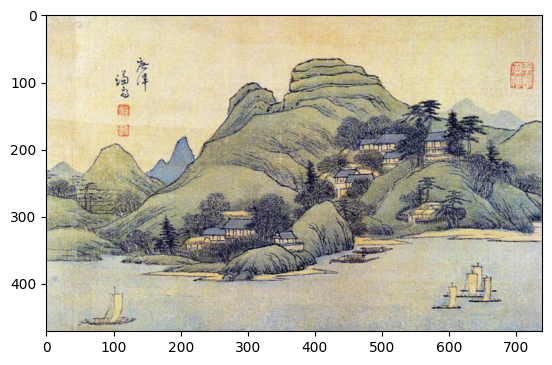

In [43]:
from matplotlib import image as mp_image
import matplotlib.pyplot as plt
img = mp_image.imread(base_image_path)
plt.imshow(img)
plt.show()

img = mp_image.imread(style_reference_image_path)
plt.imshow(img)
plt.show()

In [44]:
# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [45]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [46]:
# 이미지 텐서의 gram matrix (특징별 outer product)

def gram_matrix(x):
    # 채널을 맨 앞으로, w,h를 뒤로 보냄
    x = tf.transpose(x, (2, 0, 1))
    # (c, h, w) ==> (c, w*h)
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    # (c, w*h) x (w*h,c) = (c,c)
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [47]:
# style loss는 reference image와 generated image간의
# 스타일 차이를 유지할 수 있도록 하는 역할을 한다.
# gram matrix의 차이의 squared error로 정의

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    # 논문의 정확한 implementation은 다음과 같아야 함
    # channels = style.shape[2]
    # size = style.shape[0] * style.shape[1]
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


In [48]:
# 콘텐츠 손실 함수
# 생성된 이미지에서 base 이미지의 "content"를
# 유지하기 위함

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [49]:
# 3번째 손실함수: total variation loss
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [50]:
# VGG19 model 로딩 (pre-trained ImageNet weights)
model = vgg19.VGG19(weights="imagenet", include_top=False)
model.summary()

# 모델에서 레이어 이름과 레이어 출력 형식을 가져옴
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# VGG 모델의 전체 activation value를 출력하는 함수 정의
# (dict 형식)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [51]:
# style loss에 사용할 레이어
#style_layer_names = [
#    "block1_conv1",
#    "block2_conv1",
#    "block3_conv1",
#    "block4_conv1",
#    "block5_conv1",
#]

style_layer_names = [
    "block1_conv2",
    "block2_conv2",
    "block3_conv2",
    "block4_conv2",
    "block5_conv2",
]

# content loss에 사용할 레이어
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # loss 초기화
    loss = tf.zeros(shape=())

    # content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    c_loss = content_weight * content_loss(
        base_image_features, combination_features
    )
    s_loss = tf.zeros(shape=())
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        s_loss += (style_weight / len(style_layer_names)) * sl

    # total variation loss
    t_loss = total_variation_weight * total_variation_loss(combination_image)
    loss = c_loss+s_loss+t_loss
    return loss, c_loss, s_loss, t_loss

In [52]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, t_loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads, c_loss, s_loss, t_loss

In [55]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads, c_loss, s_loss, t_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0 or i == 1:
        print("Iteration %d: loss=%.2f, content_loss=%.2f, style_loss=%.2f, total_variation_loss=%.2f" %
               (i, loss, c_loss, s_loss, t_loss))
    if i % 100 == 0:
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 1: loss=338295.31, content_loss=0.00, style_loss=336756.69, total_variation_loss=1538.62
Iteration 10: loss=33820.38, content_loss=18.14, style_loss=32286.54, total_variation_loss=1515.70
Iteration 20: loss=18114.67, content_loss=20.64, style_loss=16595.68, total_variation_loss=1498.35
Iteration 30: loss=13331.12, content_loss=21.98, style_loss=11850.45, total_variation_loss=1458.69
Iteration 40: loss=10885.52, content_loss=22.84, style_loss=9444.77, total_variation_loss=1417.91
Iteration 50: loss=9339.94, content_loss=23.44, style_loss=7935.32, total_variation_loss=1381.18
Iteration 60: loss=8462.20, content_loss=24.16, style_loss=7085.22, total_variation_loss=1352.81
Iteration 70: loss=7546.31, content_loss=24.10, style_loss=6202.11, total_variation_loss=1320.10
Iteration 80: loss=6858.83, content_loss=24.40, style_loss=5541.64, total_variation_loss=1292.79
Iteration 90: loss=6317.23, content_loss=24.83, style_loss=5021.15, total_variation_loss=1271.26
Iteration 100: loss=5

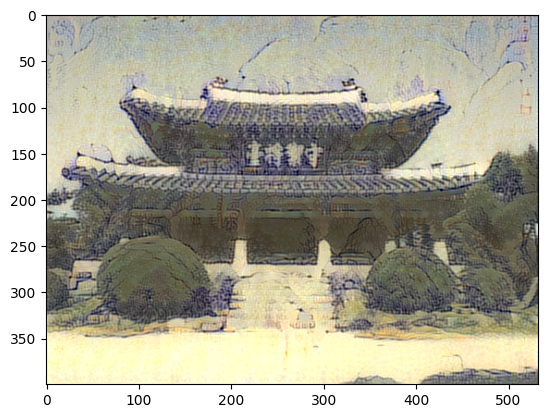

In [56]:
img = mp_image.imread(result_prefix + '_at_iteration_'+'%d.png'%4000)
plt.imshow(img)
plt.show()